In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import os
import re
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.filters import threshold_otsu

In [52]:
# Set the device for computation (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
class CNN(nn.Module): # results in accuracy of 73.22%
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.pool(self.leaky_relu(self.conv3(x)))
        x = self.pool(self.leaky_relu(self.conv4(x)))
        x = self.pool(self.leaky_relu(self.conv5(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [54]:
# Create training dataset
# Set up the data directories
sets = ['Train_510','Train_1020','Train_2040','Train_4080','Train_8160','Train_10200']
for item in sets:
    data_dir = 'Test_Images'
    train_dir = os.path.join(data_dir, item)

    # Define a function to get the labels from the image filenames
    def get_label(filename):
        match = re.search(r'\d+\.?\d*', filename)
        if match:
            return float(match.group())
        else:
            return None

    # Define a list to store the image filenames and labels
    train_data = []

    # Iterate over the training images and add them to the list
    for filename in os.listdir(train_dir):
        label = get_label(filename)
        if label is not None:
            train_data.append([os.path.join(train_dir, filename), label])

    # Convert the list to a dataframe
    train_df = pd.DataFrame(train_data, columns=['filename', 'label'])

    # Save the dataframe to a CSV file
    train_df.to_csv(os.path.join(data_dir, item+'.csv'), index=False)

In [55]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = self._load_data(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def _load_data(self, csv_file):
    # Load and preprocess data from the CSV file
    # Example: Assuming the CSV file has two columns representing image paths and labels
        data = []
        with open(csv_file, 'r') as file:
            lines = file.readlines()
            for line in lines[1:]:  # Skip the header row
                # Split the line by comma or any other appropriate delimiter
                image_path, label = line.strip().split(',')
                data.append((image_path, float(label)))  # Parse the label as float
        return data



In [56]:
input_image = Image.open('Test_Images\Train_8160\drop_s30_v5_r0.5_str6_pos0_cam2.png')  # Replace 'input_image.jpg' with the path to your input image file
transform = ToTensor()
tensor = transform(input_image)
# Calculate mean and standard deviation
mean = torch.mean(tensor)
std = torch.std(tensor)

# Normalize the data
normalizer = Normalize(mean=[mean.item(), mean.item(), mean.item()], std=[std.item(), std.item(), std.item()])
# Set up the data
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean= [mean, mean, mean], std=[std, std, std])               # Need to be adjusted, acording to dataset
])

# Define the transformation for binarizing the inputs
threshold = 0.5  # Set your desired threshold value
binarize_transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.where(x < threshold, torch.tensor(0.), torch.tensor(1.))),
])

In [57]:
# Example usage:
csv_file = 'Test_Images/Train_10200.csv'  # Replace with the path to your CSV file
image_folder = 'Test_Images/Train_10200'  # Replace with the path to your image folder


# Split the dataset into training and validation sets
dataset = CustomImageDataset(csv_file, image_folder, transform=transform)
# Define the sizes for your training, validation, and test sets
train_size = int(0.6 * len(dataset))  # 60% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 20% for test

# Use random_split to split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [58]:
# # Define the loss function and optimizer
# model = CNN()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# model

In [59]:
# Define training counstants
num_epochs = 30
best_val_loss = float('inf')
best_learning_rate = None
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter to track the number of epochs without improvement
learning_rate = 0.001

# Create empty lists
train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses
epoch_numbers = [] # List to store epoch numbers


# Define the loss function and optimizer
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
        running_loss = 0.0

        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            inputs = inputs.to(device)  # Move inputs to the device
            labels = labels.to(device)  # Move labels to the device

             # Binarize inputs
            threshold = 0.5
            inputs = torch.where(inputs >= threshold, torch.ones_like(inputs), torch.zeros_like(inputs))
            inputs = inputs[:, :1, :, :]

            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels.float())

            l1_lambda = 0.01
            l1_regularization = torch.tensor(0.).to(device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1).to(device)
            loss += l1_lambda * l1_regularization

            l2_lambda = 0.01
            l2_regularization = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_regularization += torch.norm(param, 2).to(device)
            loss += l2_lambda * l2_regularization

            running_loss += loss.item()

            loss.backward()
            optimizer.step()

            if i % 100 == 99:
                print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_samples = 0
            for inputs, labels in val_loader:
                inputs = inputs.to(device)  # Move inputs to the device
                labels = labels.to(device)  # Move labels to the device

                # Binarize inputs
                threshold = 0.5
                inputs = torch.where(inputs >= threshold, torch.ones_like(inputs), torch.zeros_like(inputs))
                inputs = inputs[:, :1, :, :]
                
                outputs = model(inputs)
                labels = labels.unsqueeze(1)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)

            average_val_loss = val_loss / val_samples

            train_losses.append(running_loss / len(train_loader))
            val_losses.append(average_val_loss)

            epoch_numbers.append(epoch + 1)
            print('Epoch %d - Training Loss: %.6f - Validation Loss: %.6f - Learning Rate: %.3f' % (epoch + 1, running_loss / len(train_loader), average_val_loss, learning_rate))

        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            counter = 0
            torch.save(model.state_dict(), f'trained_model_{item}.pt')

        else:
            counter += 1
            if counter >= patience:
                print('No improvement in validation loss. Early stopping.')
                break

        print('Epoch %d completed.' % (epoch + 1))

# Plotting the losses
# epochs = range(1, num_epochs + 1)
plt.plot(epoch_numbers, train_losses, label='Training Loss')
plt.plot(epoch_numbers, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


[1,   100] loss: 832.110983


KeyboardInterrupt: 

In [ ]:
model = torch.load('trained_model')  # Replace 'trained_model.pth' with the path to your trained model file

# Load and preprocess the input image
input_image = Image.open('Test_Images\Train\drop_s30_v5_r0.5_str6_pos0_cam79.png')  # Replace 'input_image.jpg' with the path to your input image file
input_image = input_image.convert('RGB')
input_tensor = transform(input_image)

# input_tensor = torchvision.transforms.ToTensor()(input_image).unsqueeze(0)  # Preprocess the image and add a batch dimension
input_tensor.shape

torch.Size([3, 64, 64])

In [ ]:
model = CNN()  # Replace YourModel with your actual model class
# Load the trained weights
model.load_state_dict(torch.load('trained_model'))

# Access the weights
weights = model.state_dict()

# Print the weights
for name, param in weights.items():
    print(f'Weights:\n{param}')

Weights:
tensor([[[[ 6.1744e-02, -1.7227e-02, -1.7797e-01],
          [-9.8384e-02,  1.0451e-01, -1.1212e-01],
          [-2.3400e-02,  7.3192e-02,  1.0622e-02]],

         [[-5.0237e-02, -1.0561e-01, -6.1587e-03],
          [-4.5532e-02, -1.8293e-02,  7.3202e-02],
          [-7.7207e-03, -1.7356e-01,  9.8020e-02]],

         [[-2.1457e-01,  2.8163e-02,  3.0453e-02],
          [-1.3877e-01,  7.4286e-02, -1.5556e-01],
          [ 7.1053e-03, -2.3738e-02, -5.7871e-02]]],


        [[[ 1.2624e-01,  1.5454e-01,  1.2065e-01],
          [ 1.2982e-01,  1.5356e-01,  6.9141e-02],
          [ 5.4578e-02,  1.5468e-01,  9.7286e-02]],

         [[-3.7528e-02, -1.2446e-01,  1.7186e-01],
          [ 8.2097e-02,  1.7612e-01, -6.8418e-02],
          [-1.2273e-01,  1.2590e-01, -1.7718e-01]],

         [[ 1.6140e-03, -1.3809e-01,  7.9931e-02],
          [-7.0125e-02, -1.3291e-01,  7.3816e-02],
          [ 1.8632e-01,  1.9534e-01,  2.9400e-02]]],


        [[[ 1.7675e-02, -1.6230e-01, -1.6275e-01],
      

In [ ]:
# Set the model in evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(input_tensor)

# Convert the output to a readable format
predicted_value = output.item()

# Print the predicted value
print('Predicted value:', predicted_value)

Predicted value: 30.97287368774414


In [ ]:
# Set the device for computation (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=['Image', 'Real Value', 'Predicted Value', 'Difference'])

# Iterate over the figures in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust the file extensions as per your figures
        image_path = os.path.join(image_folder, filename)
        
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        # Extract the real value from the filename
        real_value = int(filename.split('_')[1][1:])  # Adjust the splitting pattern to extract the desired value
        
        # Make the prediction
        with torch.no_grad():
            output = model(input_tensor)
        predicted_value = output.item()
        
        # Calculate the difference between predicted and real value
        difference = predicted_value - real_value

        # Add the prediction, real value, and difference to the DataFrame
        predictions_df = predictions_df.append({'Image': filename, 'Real Value': real_value, 'Predicted Value': predicted_value, 'Difference': difference}, ignore_index=True)

# Print the predictions table
print(predictions_df)

                                       Image Real Value  Predicted Value  \
0        drop_s30_v5_r0.5_str6_pos0_cam0.png         30        30.825785   
1        drop_s30_v5_r0.5_str6_pos0_cam1.png         30        29.626762   
2       drop_s30_v5_r0.5_str6_pos0_cam10.png         30        28.062374   
3      drop_s30_v5_r0.5_str6_pos0_cam100.png         30        30.943573   
4      drop_s30_v5_r0.5_str6_pos0_cam101.png         30        30.909718   
...                                      ...        ...              ...   
10195   drop_s80_v5_r0.5_str6_pos0_cam95.png         80        78.796661   
10196   drop_s80_v5_r0.5_str6_pos0_cam96.png         80        78.629028   
10197   drop_s80_v5_r0.5_str6_pos0_cam97.png         80        78.437439   
10198   drop_s80_v5_r0.5_str6_pos0_cam98.png         80        78.413086   
10199   drop_s80_v5_r0.5_str6_pos0_cam99.png         80        78.282021   

       Difference  
0        0.825785  
1       -0.373238  
2       -1.937626  
3      

Mean Squared Error (MSE): 0.3475041678628829


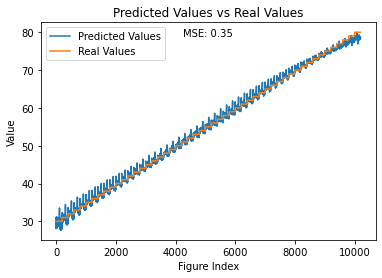

In [ ]:
# Extract the real and predicted values from the DataFrame
real_values = predictions_df['Real Value']
predicted_values = predictions_df['Predicted Value']

# Calculate the mean squared error (MSE)
differences = predictions_df['Difference']
mse = np.mean(differences ** 2)

# Print MSE
print('Mean Squared Error (MSE):', mse)

# Plot the predicted values and the real values
plt.plot(predicted_values, label='Predicted Values')
plt.plot(real_values, label='Real Values')
plt.xlabel('Figure Index')
plt.ylabel('Value')
plt.title('Predicted Values vs Real Values')
plt.legend()

# Display the MSE in the plot
plt.text(0.5, 0.95, f'MSE: {mse:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

# Show the plot
plt.show()

MSE per Real Value:
Real Value
30    0.674088
31    0.389522
32    0.314542
33    0.311041
34    0.307562
35    0.291846
36    0.281125
37    0.274643
38    0.267425
39    0.256583
40    0.243656
41    0.240606
42    0.234849
43    0.229349
44    0.228636
45    0.229550
46    0.225106
47    0.218011
48    0.205359
49    0.202608
50    0.202819
51    0.205302
52    0.203779
53    0.201267
54    0.203599
55    0.208990
56    0.222075
57    0.247110
58    0.268688
59    0.293509
60    0.327963
61    0.354337
62    0.368110
63    0.372606
64    0.367826
65    0.367258
66    0.371546
67    0.366505
68    0.363032
69    0.335829
70    0.291531
71    0.226544
72    0.166348
73    0.118346
74    0.100298
75    0.132167
76    0.248211
77    0.479529
78    0.863831
79    1.411609
80    2.206041
Name: Difference, dtype: float64


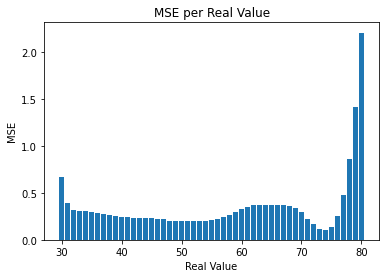

In [ ]:
# Calculate the MSE per real value
mse_per_real_value = predictions_df.groupby('Real Value')['Difference'].apply(lambda x: mean_squared_error(x, np.zeros_like(x)))

# Print the MSE per real value
print('MSE per Real Value:')
print(mse_per_real_value)

# Plot the MSE per real value
plt.bar(mse_per_real_value.index, mse_per_real_value)
plt.xlabel('Real Value')
plt.ylabel('MSE')
plt.title('MSE per Real Value')

# Show the plot
plt.show()

In [ ]:
# Create a DataFrame to store the predictions
predictions_test_df = pd.DataFrame(columns=['Real Value', 'Predicted Value', 'Difference'])


# Set the model to evaluation mode
model.eval()

# Initialize variables for tracking correct predictions and total samples
correct_predictions = 0
total_samples = 0

# Define the range for considering a prediction as correct
max_range = 0.5

# Iterate over the test data
for sample in test_loader:

    # Move the input data to the device
    inputs = sample[0].to(device)  # Assuming the input images are the first element in each sample
    labels = sample[1].to(device)  # Assuming the labels are the second element in each sample

    # Forward pass through the model
    with torch.no_grad():
        predicted_values = model(inputs).squeeze().tolist()

    # Get the predicted labels
    predicted_labels = outputs  # Assuming the model output is a single scalar value

    # Calculate the number of correct predictions within the range
    # correct_predictions += ((predicted_labels >= min_range) & (predicted_labels <= max_range) & (labels >= min_range) & (labels <= max_range)).sum().item()
    
# Iterate over the predicted values and add them to the DataFrame
    for i in range(len(predicted_values)):
        real_value = labels[i].item()
        predicted_value = predicted_values[i]

        # Check if the predicted value is within the desired range (40-70)
        if real_value >= 40 and real_value <= 70:
            # Calculate the difference between predicted and real value
            difference = predicted_value - real_value

            # Add the prediction, real value, and difference to the DataFrame
            predictions_test_df = predictions_test_df.append({'Real Value': real_value, 'Predicted Value': predicted_value, 'Difference': difference}, ignore_index=True)

            # Check if the prediction is correct within the desired range
            if abs(real_value - predicted_value) <= max_range:
                correct_predictions += 1


# Calculate the accuracy
accuracy = correct_predictions / (len(predictions_test_df)-1)

# Print the predictions DataFrame
print(predictions_test_df)

# Print the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")



      Real Value  Predicted Value  Difference
0           47.0        46.540329   -0.459671
1           59.0        59.215633    0.215633
2           58.0        58.103199    0.103199
3           43.0        42.641548   -0.358452
4           54.0        53.509182   -0.490818
...          ...              ...         ...
1265        69.0        68.824554   -0.175446
1266        52.0        51.464405   -0.535595
1267        58.0        58.533733    0.533733
1268        43.0        42.673412   -0.326588
1269        51.0        51.008083    0.008083

[1270 rows x 3 columns]
Accuracy: 72.10%


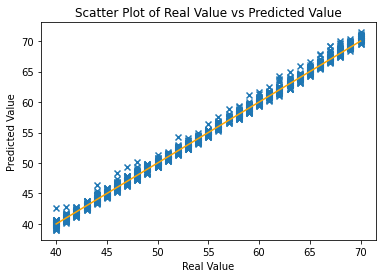

In [ ]:
# Filter the predictions_test_df to include only the range 40-70 real values $$$
filtered_predictions_test_df = predictions_test_df[(predictions_test_df['Real Value'] >= 40) & (predictions_test_df['Real Value'] <= 70)]

# Create a scatter plot
plt.scatter(filtered_predictions_test_df['Real Value'], filtered_predictions_test_df['Predicted Value'], marker='x')

# Plot the line y = x
x = np.linspace(filtered_predictions_test_df['Real Value'].min(), filtered_predictions_test_df['Real Value'].max(), 100)
plt.plot(x, x, color='orange')

# Set plot labels and title
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title('Scatter Plot of Real Value vs Predicted Value')

# Display the plot
plt.show()

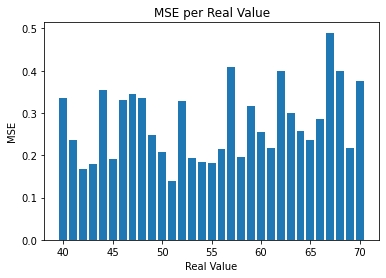

In [ ]:
# Calculate the MSE per real value
mse_per_real_value_test = filtered_predictions_test_df.groupby('Real Value')['Difference'].apply(lambda x: mean_squared_error(x, np.zeros_like(x)))

# Plot the MSE per real value
plt.bar(mse_per_real_value_test.index, mse_per_real_value_test)
plt.xlabel('Real Value')
plt.ylabel('MSE')
plt.title('MSE per Real Value')

# Show the plot
plt.show()